# SIMULATIONS
## Import and helper functions

In [1]:
import workload_simulation
import forgetting_curve as fc
import matplotlib
import importlib
import numpy
from operator import itemgetter

ModuleNotFoundError: No module named 'matplotlib'

In [9]:
importlib.reload(workload_simulation)
import workload_simulation as ws

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
SimulationResult = ws.SimulationResult
%matplotlib inline

In [68]:
def get_closest_factor(new_factor, total_output):
    for r in total_output:
        if r.factor >= new_factor:
            return r

In [72]:
def analysis(total_output, cost_new_card=0, new_factor=None):
    eff_func = newefficiency(cost_new_card)
    factors = [output.factor for output in total_output]
    r_rates = [output.r_rate for output in total_output]
    w_loads = [output.w_load+cost_new_card + cost_new_card for output in total_output]
    effs = [eff_func(output) for output in total_output]
    
    sm2 = get_SM2_Point(total_output)
    print("before")
    print(sm2)
    closest_new_factor = get_closest_factor(new_factor, total_output)
    print("after")
    print(closest_new_factor)
    print("comparisons")
    print(compare(closest_new_factor, sm2, cost_new_card=cost_new_card))
    
    plt.scatter(factors, r_rates,  color='blue')
    #t = np.polyfit(factors,r_rates,1)
    #new_rates = [t[0]*f + t[1] for f in factors]
    #plt.plot(factors,new_rates, color="red")
    plt.xlabel("Factors")
    plt.ylabel("Retention rate")
    if new_factor is not None:
        plt.plot([new_factor, new_factor], [min(r_rates), max(r_rates)], color="green", lw=1)
    plt.plot([2.5, 2.5], [min(r_rates), max(r_rates)], 'k-', lw=1)
    plt.show()
    plt.scatter(factors, w_loads,  color='red')
    plt.xlabel("Factors")
    plt.ylabel("workload")
    if new_factor is not None:
        plt.plot([new_factor, new_factor], [min(w_loads), max(w_loads)], color="green", lw=1)   
    plt.plot([2.5, 2.5], [min(w_loads), max(w_loads)], 'k-', lw=1)
    plt.show()
    plt.scatter(factors, effs,  color='green')
    if new_factor is not None:
        plt.plot([new_factor, new_factor], [min(effs), max(effs)], color="green", lw=1)  
    plt.plot([2.5, 2.5], [min(effs), max(effs)], 'k-', lw=1)
    t = np.polyfit(factors,effs, 3)
    #new_effs = [t[0]*f*f*f + t[1]*f*f + t[2]*f + t[3] for f in factors]
    #plt.plot(factors,new_effs, color="blue")
    plt.xlabel("Factors")
    plt.ylabel("efficiency")
    plt.show()
    print("outputs : recall proba, real retention rate, workload, retention/workload")
    best_productivity = max(total_output, key=eff_func)
    print("best_productivity")
    print(best_productivity)
    print("factor used")
    print(best_productivity.factor)

    least_work = min(total_output, key=itemgetter(2))
    print("least work")
    print(least_work)
    print("factor used")
    print(least_work[4])
#analysis(total_output)

In [51]:
def get_SM2_Point(results):
    for r in results:
        if r.factor == 2.5:
            return r

def compare(source, target, cost_new_card):
    return SimulationResult(source.pbt - target.pbt, source.r_rate - target.r_rate, 
                            (source.w_load + cost_new_card)/(target.w_load + cost_new_card), source.efficiency/target.efficiency, source.factor/target.factor)

def compare_best_to_sm2(results, cost_new_card=5):
    o = get_best_prod(results, cost_new_card)
    s = get_SM2_Point(results)
    return compare (o, s, cost_new_card)

def get_best_prod(results, cost_new_card):
    return max(results, key=newefficiency(cost_new_card))

def newefficiency(cost_new_card):
    def eff(sim):
        return sim.r_rate/(sim.w_load + cost_new_card)
    return eff

## Run an analysis for a specific success rate

In [ ]:
dif = 0.73

In [4]:
vals_to_print = []
total_output = []
# trick to get this kind of factor 1.0, 1.1, 1.2, 1.25, 1.3, 1.3333333333333333
# Why ? These factors produce sensible enough different simulations because intervals are integers 
# Intervals get rounded if they become float, so for the sake of the simulation, let's pick factors that
# would result in neat intervals

# How ? : take floats that would be close to integers when multiplied by common integers
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=4000, onfail="reset", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)

In [ ]:
analysis(total_output)

## Analysis of the result of simulations accross range of success rates

In [8]:
import csv
results = []
with open("./simunight2.txt","r") as fmulti:
    fmulticsv = csv.reader(fmulti, delimiter=" ")
    for row in fmulticsv:
        res = ws.SimulationResult(*row[1:])._asdict()
        res["pbt"] = row[0]
        results.append(res)

In [9]:
results

[OrderedDict([('pbt', '70.0'),
              ('r_rate', '0.8179584310597515'),
              ('w_load', '18.9886'),
              ('efficiency', '0.04307628951369514'),
              ('factor', '3.8')]),
 OrderedDict([('pbt', '70.5'),
              ('r_rate', '0.8308914836076625'),
              ('w_load', '18.7141'),
              ('efficiency', '0.04439922216978976'),
              ('factor', '3.5')]),
 OrderedDict([('pbt', '71.0'),
              ('r_rate', '0.8282913885594954'),
              ('w_load', '18.1565'),
              ('efficiency', '0.045619551596370184'),
              ('factor', '3.6666666666666665')]),
 OrderedDict([('pbt', '71.5'),
              ('r_rate', '0.8367669930411895'),
              ('w_load', '17.6852'),
              ('efficiency', '0.0473145337932955'),
              ('factor', '3.5')]),
 OrderedDict([('pbt', '72.0'),
              ('r_rate', '0.834714555212902'),
              ('w_load', '17.1227'),
              ('efficiency', '0.04874900309021954'),
 

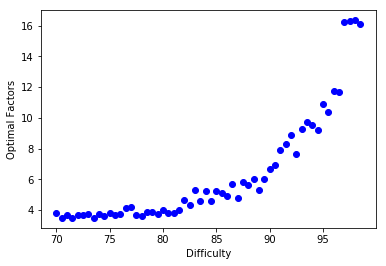

In [17]:
factors = [float(output["factor"]) for output in results]
pbt = [float(output["pbt"]) for output in results]
w_load = [float(output["w_load"]) for output in results]
r_rate = [float(output["r_rate"]) for output in results]
plt.scatter(pbt, factors, color="blue")
t = np.polyfit(np.asarray(pbt, dtype=float),np.asarray(factors, dtype=float),2)
#new_factors = [t[0]*p*p + t[1]*p + t[2] for p in pbt]
#plt.plot(pbt,new_factors, color="red")
plt.ylabel("Optimal Factors")
plt.xlabel("Difficulty")
plt.show()

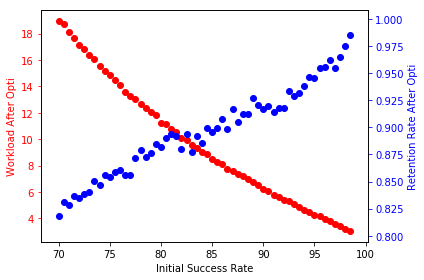

In [26]:
fig, ax1 = plt.subplots()
ax1.scatter(pbt, w_load, color="red")
ax1.set_xlabel('Initial Success Rate')
ax1.set_ylabel('Workload After Opti', color='red')
ax1.tick_params('y', colors='red')

ax2 = ax1.twinx()
ax2.scatter(pbt, r_rate, color="blue")
ax2.set_ylabel('Retention Rate After Opti', color='blue')
ax2.tick_params('y', colors='blue')

fig.tight_layout()
plt.show()

## Gains over SM2

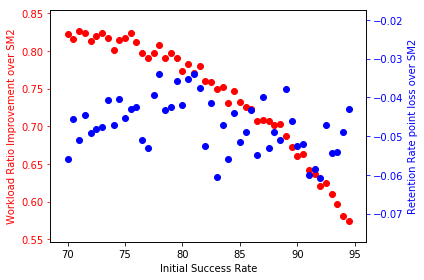

In [35]:
wlds = []
rets = []
difs = []
for dif10 in range(700,950,5):
    dif = dif10/10
    path = f"./simunight/{dif}.pkl"
    wlds.append(compare_best_to_sm2(ws.get_simdata(path)).w_load)
    rets.append(compare_best_to_sm2(ws.get_simdata(path)).r_rate)
    difs.append(dif)
fig, ax1 = plt.subplots()
ax1.scatter(difs, wlds, color="red")
ax1.set_xlabel('Initial Success Rate')
ax1.set_ylabel('Workload fraction (SM2=1)', color='red')
ax1.tick_params('y', colors='red')

ax2 = ax1.twinx()
ax2.scatter(difs, rets, color="blue")
ax2.set_ylabel('Retention Rate point loss over SM2', color='blue')
ax2.tick_params('y', colors='blue')

fig.tight_layout()
plt.show()

Retention rate point loss is distributed between -3pt and -6pts whereas workload diminish fast with Initial Success rate.

Two practical implications :
1. Whatever your initial success rate, if you use the suggested IM, the retention loss is not large.
2. If you have a large Initial Success Rate, you have more interests to use optimized IM's.

## Analysis of the result of specific past simulations

In [ ]:
v = ws.get_simdata("./simunight/70.0.pkl")
analysis(v)
v = ws.get_simdata("./simunight/85.0.pkl")
analysis(v)
v = ws.get_simdata("./simunight/95.0.pkl")
analysis(v)

In [ ]:
compare_best_to_sm2(ws.get_simdata("./simunight/70.0.pkl"))

In [ ]:
compare_best_to_sm2(ws.get_simdata("./simunight/90.0.pkl"))


In [ ]:
compare_best_to_sm2(ws.get_simdata("./simunight/95.0.pkl"))

## Partial reset mode (failed cards are partially reset)

## diff 90%

In [ ]:
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
dif = 0.90
total_output = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=1000, onfail="stable", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)
analysis(total_output)
compare_best_to_sm2(total_output)

##  70% success rate

In [ ]:
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
dif = 0.70
total_output = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=1000, onfail="stable", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)
analysis(total_output)
compare_best_to_sm2(total_output)

##  95% success rate

In [ ]:
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
dif = 0.95
total_output = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=1000, onfail="stable", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)
analysis(total_output)
compare_best_to_sm2(total_output)

## Work to create a card

In [22]:
cost_new_card = 8

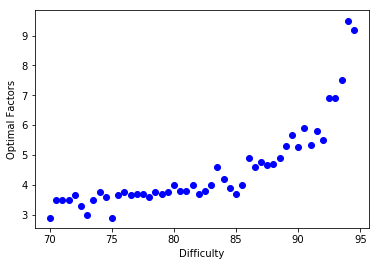

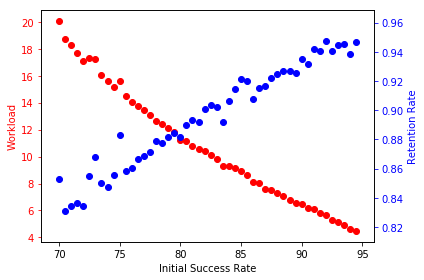

In [23]:
wlds = []
rets = []
difs = []
optis = []
factors = []
effs = []

c_wlds = []
c_rets = []
c_effs = []
for dif10 in range(700,950,5):
    dif = dif10/10
    path = f"./simunight/{dif}.pkl"
    sims = ws.get_simdata(path)
    eff_func = newefficiency(cost_new_card)
    best = max(sims, key=eff_func)
    optis.append(best)
    wlds.append(best.w_load)
    difs.append(dif)
    rets.append(best.r_rate)
    factors.append(best.factor)
    effs.append(eff_func(best))
    
    comparesim = compare_best_to_sm2(sims, cost_new_card=cost_new_card)
    c_wlds.append(comparesim.w_load)
    c_rets.append(comparesim.r_rate)
    c_effs.append(comparesim.efficiency)
    

plt.scatter(difs, factors, color="blue")
#t = np.polyfit(np.asarray(pbt, dtype=float),np.asarray(factors, dtype=float),2)
#new_factors = [t[0]*p*p + t[1]*p + t[2] for p in pbt]
#plt.plot(pbt,new_factors, color="red")
plt.ylabel("Optimal Factors")
plt.xlabel("Difficulty")
plt.show()
    
fig, ax1 = plt.subplots()
ax1.scatter(difs, wlds, color="red")
ax1.set_xlabel('Initial Success Rate')
ax1.set_ylabel('Workload', color='red')
ax1.tick_params('y', colors='red')

ax2 = ax1.twinx()
ax2.scatter(difs, rets, color="blue")
ax2.set_ylabel('Retention Rate', color='blue')
ax2.tick_params('y', colors='blue')

fig.tight_layout()
plt.show()

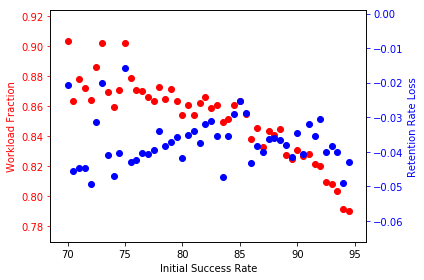

In [24]:
fig, ax1 = plt.subplots()
ax1.scatter(difs, c_wlds, color="red")
ax1.set_xlabel('Initial Success Rate')
ax1.set_ylabel('Workload Fraction', color='red')
ax1.tick_params('y', colors='red')

ax2 = ax1.twinx()
ax2.scatter(difs, c_rets, color="blue")
ax2.set_ylabel('Retention Rate Loss', color='blue')
ax2.tick_params('y', colors='blue')

fig.tight_layout()
plt.show()

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [42]:
analysis(total_output, cost_new_card)

NameError: name 'total_output' is not defined

In [66]:
def f(success_rate, cost_card, new_factor):
    path = f"./simunight/{success_rate}.pkl"
    sims = ws.get_simdata(path)
    print("IM :"+ str(new_factor/2.5))
    return analysis(sims, cost_new_card, new_factor)

In [73]:
interact(f, success_rate=widgets.FloatSlider(min=70,max=97,step=0.5,value=90), 
         cost_card=widgets.IntSlider(min=0,max=15,step=1,value=5),
         new_factor=widgets.FloatSlider(min=2,max=20,step=0.1,value=4)
        );

interactive(children=(FloatSlider(value=90.0, description='success_rate', max=97.0, min=70.0, step=0.5), IntSl…